# Задание 3. Оптимизация портфеля и построение эффективной границы

# Цель задания:
### 1. Рассмотреть вычислительные библиотеки языка Python
### 2. Рассмотреть различные подходы к построению оптимального портфеля
### 3. Построить эффективную границу и подобрать параметры CML

### Рекомендуемая литература:
### 1.Y.Hilpish "Python for Finance"
### 2.J.M. Weiming "Mastering Python for Finance"
### 3.W. McKinney "Python for Data Analysis"

## 1. Загрузка библиотек

In [1]:
import numpy as np
import pandas as pd

In [2]:
from __future__ import division

In [3]:
import matplotlib.pyplot as plt # графическая библиотека
%matplotlib inline 

In [4]:
from os import listdir

In [5]:
from os.path import isfile,join # функции, необходимые для работы с файлами и директориями

In [6]:
import scipy.optimize as sco # оптимизация

In [7]:
import scipy.interpolate as sci # интерполяция (подбор функций)

In [8]:
from functools import reduce

## 2. Загрузка данных и их преобразование в необходимый формат

In [9]:
path='/Users/massimozharkovsky/Documents/ML/Derivatives/VAR'

In [10]:
Tickers=['AAPL','JNJ','BAC','NKE']# выбранные для анализа активы

In [11]:
files=[f for f in listdir(path) if (isfile(join(path,f))&(f.endswith('csv')))] 
# создание списка имен файлов 

In [12]:
# создание массива, содержащего даты и цены закрытия для каждого актива
df_list=[]
for f in files:
    fname=join(path,f)
    print (fname)
    df=pd.read_csv(fname,usecols=['Date','Close'],parse_dates=['Date'])
    new_col_name=f[0:(len(f)-4)]
    df.rename(columns={'Close':new_col_name},inplace=True)
    df_list.append(df)

/Users/massimozharkovsky/Documents/ML/Derivatives/VAR/BAC.csv
/Users/massimozharkovsky/Documents/ML/Derivatives/VAR/NKE.csv
/Users/massimozharkovsky/Documents/ML/Derivatives/VAR/AAPL.csv
/Users/massimozharkovsky/Documents/ML/Derivatives/VAR/JNJ.csv


In [13]:
port=reduce(lambda left,right: pd.merge(left,right,on=['Date']),df_list)
# объединение активов в один массив (dataframe)

In [14]:
port.dropna(inplace=True)

In [15]:
port_log=port.copy()

In [16]:
port_log.index=port_log.Date

In [17]:
port_log.drop(columns=['Date'],inplace=True)

In [18]:
port_log=port_log.apply(lambda x:np.log(x)-np.log(x).shift(1))
### расчет логарифмической доходности для каждого актива

In [19]:
port_log=port_log.iloc[1:,:]

In [20]:
port_log.head()

,BAC,NKE,AAPL,JNJ
Date,,,,
2014-02-19,-0.016529,-0.005199,-0.015914,-0.005767
2014-02-20,0.006154,0.010106,-0.011642,0.008043
2014-02-21,-0.000614,0.011838,-0.011170,-0.009353
2014-02-24,0.014625,0.017626,0.004369,-0.004490
2014-02-25,-0.011561,0.003463,-0.010461,0.000000


In [21]:
port_log.shape

(1231, 4)

## 3. Полезные функции

In [22]:
# доходность портфеля
def port_mean(weights,means,n_days=250):
    weights=np.array(weights)
    return (np.sum(means*weights)*n_days)

In [23]:
# дисперсия портфеля
def port_variance(weights,cov,n_days=250):
    weights=np.array(weights)
    return (np.dot(weights.T,np.dot(cov*n_days,weights)))

In [24]:
# волатильность портфеля
def port_vol(weights,cov,n_days=250):
    weights=np.array(weights)
    return (np.sqrt(np.dot(weights.T,np.dot(cov*n_days,weights))))

In [25]:
# Sharpe ratio портфеля
def Sharpe_ratio(weights,cov,means,r_f,n_days=250):
    weights=np.array(weights)
    mean=np.sum(means*weights)*n_days
    vol=np.sqrt(np.dot(weights.T,np.dot(cov*n_days,weights)))
    return -((mean-r_f)/vol)

In [26]:
# генерация портфелей со случайными весами
def sim_func(N_sim,n_means,cov,n_days=250):
    lrets=[]
    lvols=[]
    n_assets=len(means)
    for i in range(N_sim):
        weights=np.random.random(n_assets)
        weights/=np.sum(weights)
        lrets.append(port_mean(weights,means,n_days))
        lvols.append(port_vol(weights,cov,n_days))
    return(np.array(lrets),np.array(lvols))   

In [27]:
# специальная функция для интерполяции сплайнами
def f(x,tck):
    return sci.splev(x,tck,der=0)

In [28]:
# специальная функция для интерполяции сплайнами (первая производная)
def df(x,tck):
    return sci.splev(x,tck,der=1)

In [29]:
# подбор параметров CML
def equations(p,r_f,tck):
    eq1=r_f-p[0]
    eq2=r_f+p[1]*p[2]-f(p[2],tck)
    eq3=p[1]-df(p[2],tck)
    return eq1,eq2,eq3

## 4. Моделирование множества портфелей

In [30]:
# Начальные параметры
r_f=.02 # безрисковая ставка
N_sim=2500# количество сгенерированных портфелей со случайными весами
n_assets=port_log.shape[1]# количество активов
n_days=250# количество торговых дней в году

In [31]:
# средние значения доходностей для каждого актива
means=np.mean(port_log)
means*n_days

BAC     0.088857
NKE     0.144833
AAPL    0.133821
JNJ     0.069779
dtype: float64

In [32]:
# портфель со случайными весами
w=np.random.random(n_assets)
w/=np.sum(w)
w

array([0.16097822, 0.1098983 , 0.29707981, 0.43204367])

In [33]:
# ковариационная матрица портфеля
cov=np.cov(port_log,rowvar=False)
cov

array([[2.58875188e-04, 8.74980452e-05, 9.20052780e-05, 5.33387268e-05],
       [8.74980452e-05, 2.21107040e-04, 7.64270764e-05, 4.70645466e-05],
       [9.20052780e-05, 7.64270764e-05, 2.34045972e-04, 4.93512378e-05],
       [5.33387268e-05, 4.70645466e-05, 4.93512378e-05, 1.02727558e-04]])

In [34]:
# кореляционная матрица портфеля
np.corrcoef(port_log,rowvar=False)

array([[1.        , 0.36572264, 0.37378076, 0.32707997],
       [0.36572264, 1.        , 0.33596604, 0.31228355],
       [0.37378076, 0.33596604, 1.        , 0.31827607],
       [0.32707997, 0.31228355, 0.31827607, 1.        ]])

In [35]:
# реализация функции генерации портфелей 
# результат - массив доходностей и волатильностей 
rets,vols=sim_func(N_sim,means,cov)

In [36]:
rets

array([0.10628442, 0.10356644, 0.11377539, ..., 0.11165746, 0.09794442,
       0.12243676])

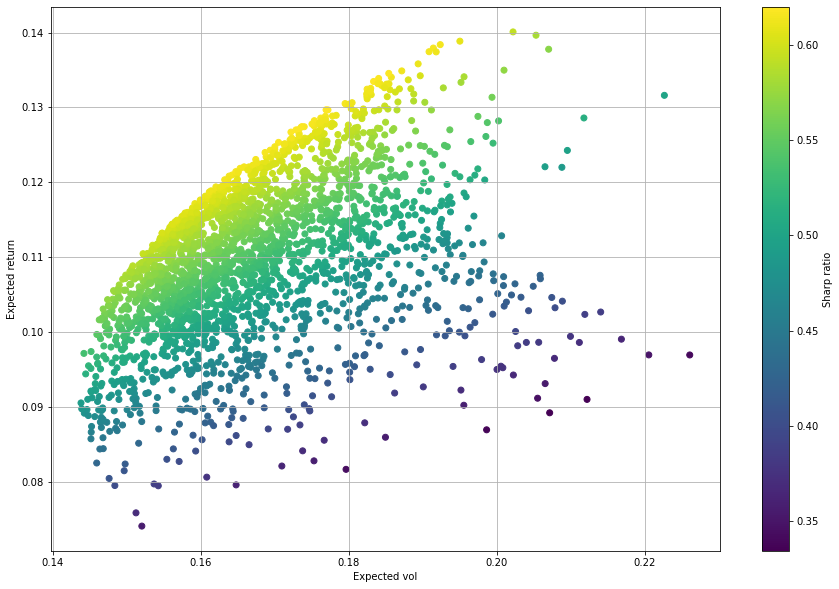

In [37]:
_=plt.figure(figsize=(15,10))
_=plt.scatter(vols,rets,c=(rets-r_f)/vols,marker='o')
_=plt.grid(True)
_=plt.xlabel('Expected vol')
_=plt.ylabel('Expected return')
_=plt.colorbar(label='Sharp ratio')

## 5. Нахождение оптимального портфеля

In [38]:
# ограничение - сумма весов не должна превышать единицу
cons=({'type':'eq','fun':lambda x:sum(x)-1})

In [39]:
# ограничение - веса находятся в диапазоне от 0 до 1
bnds=tuple((0,1) for x in range(n_assets))

In [40]:
bnds

((0, 1), (0, 1), (0, 1), (0, 1))

In [41]:
w_initial=n_assets*[1./n_assets] # первоначальные значения весов (все веса равны)

In [42]:
w_initial

[0.25, 0.25, 0.25, 0.25]

In [43]:
port_variance(w_initial,cov) # вариация портфеля с учетом начальных весов

0.02543946218021794

In [44]:
# нахождение портфеля с минимальной вариацией
optv=sco.minimize(port_variance,w_initial,(cov),method='SLSQP',bounds=bnds,constraints=cons)

In [45]:
optv

     fun: 0.02057377279537471
     jac: array([0.0411561 , 0.04116724, 0.04111944, 0.04114733])
 message: 'Optimization terminated successfully'
    nfev: 35
     nit: 7
    njev: 7
  status: 0
 success: True
       x: array([0.08926453, 0.15928974, 0.13409826, 0.61734747])

In [46]:
# значения весов портфеля с минимальной вариацией
optv['x'].round(3)

array([0.089, 0.159, 0.134, 0.617])

In [47]:
# Додходность портфеля, волатильность портфеля, Sharpe ratio
port_mean(optv['x'].round(3),means),port_vol(optv['x'].round(3),cov),-Sharpe_ratio(optv['x'].round(3),cov,means,r_f)

(0.0919222565791231, 0.1432921639626351, 0.5019273531096757)

In [48]:
# нахождение портфеля с максимальным значением коэффициента Шарпа
opts=sco.minimize(Sharpe_ratio,w_initial,(cov,means,r_f),method='SLSQP',bounds=bnds,constraints=cons)

In [49]:
opts

     fun: -0.6202093220250884
     jac: array([-0.08541106, -0.11334154, -0.11407456, -0.11341591])
 message: 'Optimization terminated successfully'
    nfev: 25
     nit: 5
    njev: 5
  status: 0
 success: True
       x: array([0.        , 0.48326624, 0.36109049, 0.15564327])

In [50]:
opts['x']

array([0.        , 0.48326624, 0.36109049, 0.15564327])

In [51]:
# значения весов портфеля с максимльным Sharpe ratio
opts['x'].round(3)

array([0.   , 0.483, 0.361, 0.156])

In [52]:
# Додходность портфеля, волатильность портфеля, Sharpe ratio
port_mean(opts['x'],means),port_vol(opts['x'],cov),-Sharpe_ratio(opts['x'],cov,means,r_f)

(0.12917467513037967, 0.17602875553999395, 0.6202093220250884)

## 5. Построение эффективной границы

In [53]:
# минимальное и максимальное значение доходности портфеля
min_ret=min(rets)
max_ret=max(rets)

In [54]:
# массив доходностей
lrets=np.linspace(min_ret,max_ret,100)

In [55]:
# массив волатильностей
lvols=[]

In [56]:
# для каждого значения доходности находим портфель с минимальной волатильностью
for ret in lrets:
    cons=({'type':'eq','fun':lambda x:sum(x)-1},\
    {'type':'eq','fun':lambda x:port_mean(x,means)-ret})
    res=sco.minimize(port_vol,w_initial,(cov),method='SLSQP',bounds=bnds,constraints=cons)
    lvols.append(res['fun'])
lvols=np.array(lvols)  # массив волатильностей эффективной границы

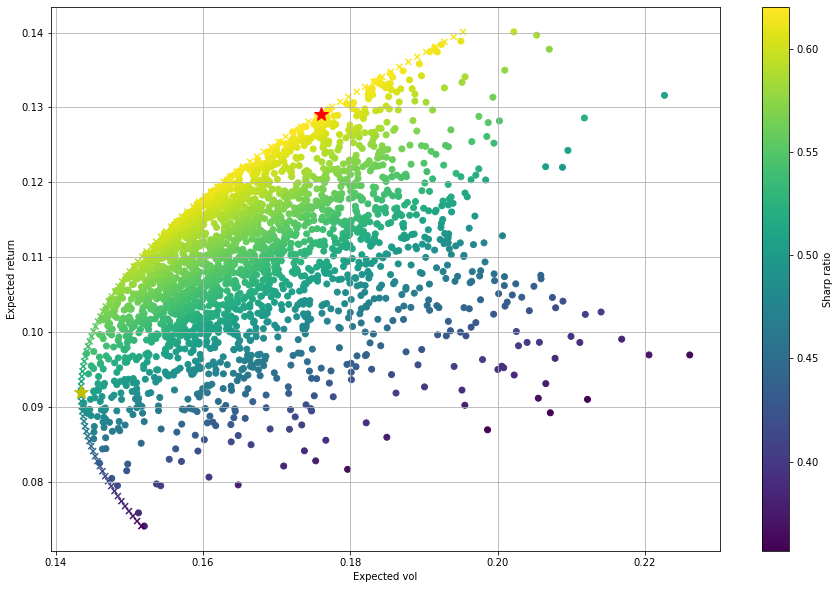

In [57]:
_=plt.figure(figsize=(15,10))
_=plt.scatter(vols,rets,c=(rets-r_f)/vols,marker='o')
_=plt.scatter(lvols,lrets,c=(lrets-r_f)/lvols,marker='x')
_=plt.plot(port_vol(opts['x'],cov),port_mean(opts['x'],means),'r*',markersize=15)
_=plt.plot(port_vol(optv['x'],cov),port_mean(optv['x'],means),'y*',markersize=15)
_=plt.grid(True)
_=plt.xlabel('Expected vol')
_=plt.ylabel('Expected return')
_=plt.colorbar(label='Sharp ratio')

## 5. Построение CML и нахождение касательного портфеля (опциональная часть задания)

In [58]:
max_vol=max(lvols)
# максмальное значение волатильности

In [59]:
# индекс значения с минимальной волатильностью в массиве волатильностей эффективной границы
ind=np.argmin(lvols)
ind

27

In [60]:
# часть эффективной границы выше минимальной волатильности 
evols=lvols[ind:]
erets=lrets[ind:]

In [61]:
evols

array([0.14343575, 0.14344975, 0.14348705, 0.14354762, 0.14363143,
       0.14373845, 0.14386862, 0.14402187, 0.14419814, 0.14439734,
       0.14461938, 0.14486415, 0.14513153, 0.1454214 , 0.14573363,
       0.14606807, 0.14642458, 0.14680298, 0.14720312, 0.14762481,
       0.14806787, 0.14853211, 0.14901733, 0.14952333, 0.15004989,
       0.15059683, 0.1511639 , 0.15175083, 0.15235743, 0.1529835 ,
       0.15362876, 0.15429299, 0.15497594, 0.15567736, 0.15639701,
       0.15713462, 0.15788996, 0.15866277, 0.15945279, 0.16025977,
       0.16108345, 0.16192358, 0.16277992, 0.16365223, 0.16454073,
       0.16544611, 0.16636809, 0.16730641, 0.1682608 , 0.16923099,
       0.17021671, 0.1712177 , 0.17223368, 0.17326349, 0.17430679,
       0.17536556, 0.17643823, 0.17752454, 0.17862425, 0.17973712,
       0.18086288, 0.18200132, 0.18315219, 0.18431526, 0.1854903 ,
       0.18667708, 0.18787538, 0.18908499, 0.19030568, 0.19153725,
       0.19277948, 0.19403218, 0.19529513])

In [62]:
erets

array([0.09209442, 0.09276109, 0.09342777, 0.09409444, 0.09476112,
       0.09542779, 0.09609446, 0.09676114, 0.09742781, 0.09809449,
       0.09876116, 0.09942784, 0.10009451, 0.10076119, 0.10142786,
       0.10209454, 0.10276121, 0.10342789, 0.10409456, 0.10476123,
       0.10542791, 0.10609458, 0.10676126, 0.10742793, 0.10809461,
       0.10876128, 0.10942796, 0.11009463, 0.11076131, 0.11142798,
       0.11209466, 0.11276133, 0.113428  , 0.11409468, 0.11476135,
       0.11542803, 0.1160947 , 0.11676138, 0.11742805, 0.11809473,
       0.1187614 , 0.11942808, 0.12009475, 0.12076143, 0.1214281 ,
       0.12209477, 0.12276145, 0.12342812, 0.1240948 , 0.12476147,
       0.12542815, 0.12609482, 0.1267615 , 0.12742817, 0.12809485,
       0.12876152, 0.1294282 , 0.13009487, 0.13076154, 0.13142822,
       0.13209489, 0.13276157, 0.13342824, 0.13409492, 0.13476159,
       0.13542827, 0.13609494, 0.13676162, 0.13742829, 0.13809497,
       0.13876164, 0.13942831, 0.14009499])

In [63]:
# интерполяция сплайнами (расчет узлов)
tck=sci.splrep(evols,erets)

In [64]:
# нахождение параметров касательной линии к эффективной границе
opt=sco.fsolve(equations,[0.02,0.3,0.15],(r_f,tck))

In [65]:
opt

array([0.02      , 0.62020948, 0.17608068])

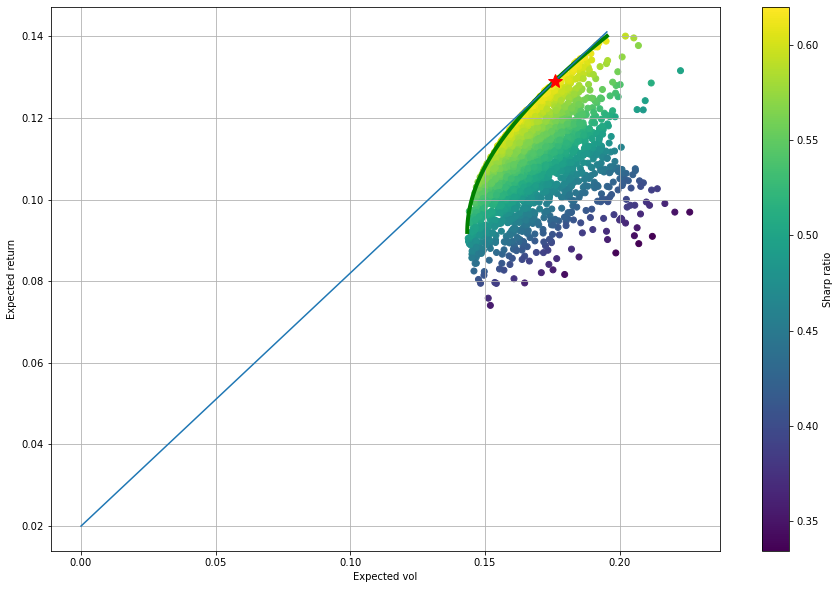

In [66]:
_=plt.figure(figsize=(15,10))
_=plt.scatter(vols,rets,c=(rets-r_f)/vols,marker='o')
_=plt.plot(evols,erets,'g',lw=4.0)
cx=np.linspace(0,max_vol)
_=plt.plot(cx,opt[0]+opt[1]*cx,lw=1.5)
_=plt.plot(opt[2],f(opt[2],tck),'r*',markersize=15)
_=plt.grid(True)
_=plt.xlabel('Expected vol')
_=plt.ylabel('Expected return')
_=plt.colorbar(label='Sharp ratio')

In [67]:
cons=({'type':'eq','fun':lambda x:port_mean(x,means)-f(opt[2],tck)},\
    {'type':'eq','fun':lambda x:np.sum(x)-1})

In [68]:
# нахождение касательного портфеля
res=sco.minimize(port_vol,w_initial,(cov),method='SLSQP',bounds=bnds,constraints=cons)

In [69]:
# веса касательного портфеля
res['x'].round(3)

array([0.   , 0.483, 0.362, 0.155])

In [70]:
# доходность портфеля
f(opt[2],tck)

array(0.12920691)

## Задание

### 1. Выбрать не менее четырех активов и построить для них различные варианты оптимальных портфелей
### 2. Для выбранных активов построить эффективную границу и найти касательный портфель
### 3. Сделать выводы